# Stack

In [1]:
import SimpleITK as sitk
import numpy as np
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import glob
import pandas as pd
import re
from itkwidgets import view
import itk

%matplotlib inline


In [2]:
#from scipy import ndimage as ndi
import VisualTools
from VisualTools import visualtools

# How is Data Acquired

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

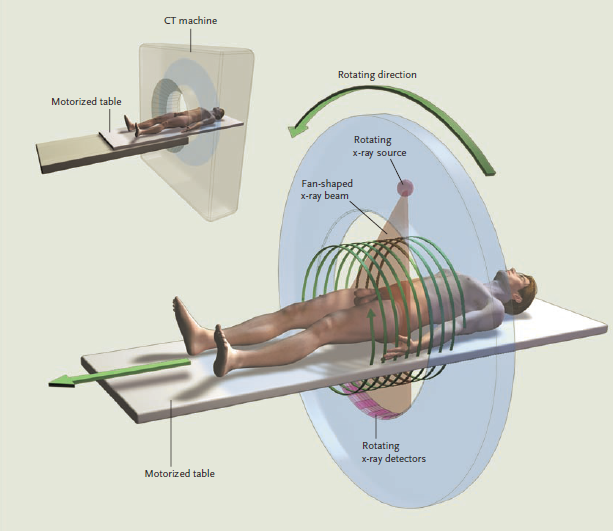

In [4]:
img="../images/helical.png"
Image(filename= img, width=450, height=500)

- Hold your breath, slide through scanner in <10 seconds
- High resolution (<1mm) 3D image of the lungs
- Very low dose possible
- No contrast material needed, very user friendly
- No high-end scanner needed: cheap (~200 k$)

## How do they look on your disk 

We have two data sets. One comes from the Luna16 grand challenge https://luna16.grand-challenge.org/ and 
the other is a limited access dataset that was used in the 2017 
DataScience Kaggle Competition.

The LUNA16 data is in Meta format and the Kaggle data is in DICOM format.
These are special formats for medical image data. 
These formats require special software to access. 
We sill use itk https://itk.org/ Insight Segmentation and 
Registration Toolkit.

For LUNA16 We have 888 patients similar to each other having underwent the above treatment. The result of each treatment was a **scan**. This scan comprises approximately 200-400 slice_images. These *slice_images* contain two parts metadata ( *.mhd) and a bytes file containing visual imagery data (*.raw). 


In [5]:
os.listdir('../data/subset0') # There about 888 such pairs

['1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.raw',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.raw']

The data for the Datascience Bowl 2017 https://www.kaggle.com/c/data-science-bowl-2017 is no longer available. However it is a subset of LIDC-IDR from National Lung Screening Trial chest CT dataset https://wiki.cancerimagingarchive.net/display/NLST/National+Lung+Screening+Trial which is a limited access dataset. However, I have managed to get my hands on a small sample which I will use for illustration purposes. 


For the LUNA16 data (similar for DICOM) there are two additional metadata files: annotations.csv and candidates.csv. 

Clinicians observe CT scans and try to identify nodules. Each line in the annotations.csv file represents an actual nodule that was discovered. Its features are a patient (seriesuid), the location of the nodule in world x,y,z coordinates and the volume of the nodule in mms.

Each line in the candidates.csv file represents a candidate nodule. Its features are a patient and the x,y,z, world
coordinates of a detected nodule and a 1/0 indicator of whether this 
candidate is actually a nodule.

Patients are identified by seriesuid

In [6]:
# Lets set our paths

luna_path= './'
luna_subset_path = luna_path+"../data/subset0/"
cand_path = luna_path +'candidates.csv'
ann_path = luna_path + 'annotations.csv'

In [7]:
# The annotations.csv and candidates.csv

df_a =pd.read_csv(ann_path,index_col='seriesuid')
df_c =pd.read_csv(cand_path,index_col='seriesuid')

print('df_a:',df_a.shape, ',','df_c:', df_c.shape)

df_a.head() 
df_c.head()


df_a: (1186, 4) , df_c: (551065, 4)


,coordX,coordY,coordZ,diameter_mm
seriesuid,,,,
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-128.699421,-175.319272,-298.387506,5.651471
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,103.783651,-211.925149,-227.121250,4.224708
1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208,69.639017,-140.944586,876.374496,5.786348
1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405,-24.013824,192.102405,-391.081276,8.143262
1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405,2.441547,172.464881,-405.493732,18.545150


,coordX,coordY,coordZ,class
seriesuid,,,,
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-56.08,-67.85,-311.92,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,53.21,-244.41,-245.17,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,103.66,-121.80,-286.62,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-33.66,-72.75,-308.41,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-32.25,-85.36,-362.51,0


# Cases

 
Now we show how to analyze a case/patient/seriesuid:

- Open and read a .mhd scan
- Visualize a .mhd scan
- Transform from world coordinates to voxel coordinates
- Iterate thru a directory of patients and also how to 
  iterate thru a scan of slices


In [8]:
def get_name(exp):
    r=re.compile(r'\.mhd$')
    return r.sub('',exp)

In [9]:
# This is a generator of cases and their identifiers
# There are only two for memory concerns 

file_list=glob.iglob(luna_subset_path+"*.mhd")
file_gen = (g for g in file_list)
names_gen = (get_name(os.path.split(f)[1]) for f in file_gen)

case = (next(file_gen), next(names_gen)) 

In [10]:
case_path  = luna_subset_path + case[1]+'.mhd'

## Each Scan

Each scan represents a patient and ITK treats each scan as a physical object in space.

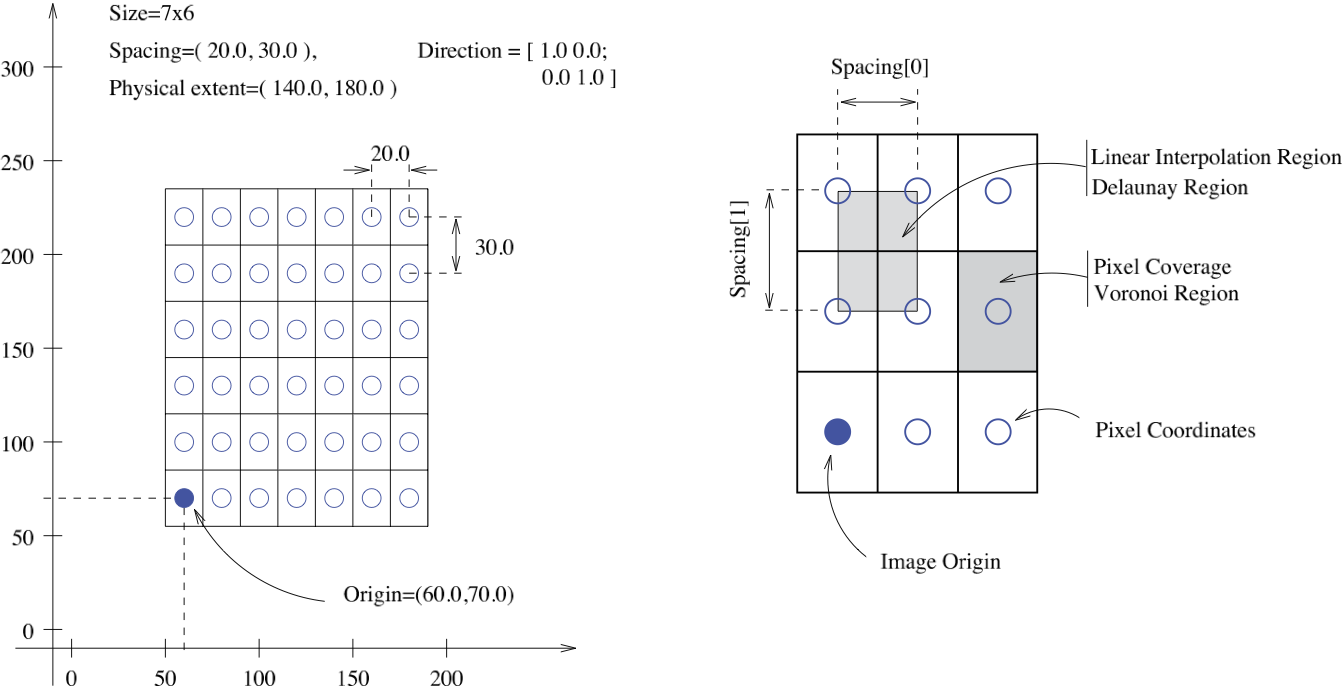

In [11]:
ios="../images/ImageOriginAndSpacing.png"
Image(filename= ios, width=800, height=800)

 **As far as python is concerned an image is an array. So images must be converted into arrays.Then we can extract the requisite information** 

In [12]:
def worldToVoxelCoord(worldCoord, origin, spacing):
     
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord



def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
     
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
     
    return numpyImage, numpyOrigin, numpySpacing

In [13]:

# load image
numpyImage, numpyOrigin, numpySpacing = load_itk_image(case_path)
#data=numpyImage
print('Shape:', numpyImage.shape)
print('Origin:',numpyOrigin)
print('Spacing:', numpySpacing)

Shape: (119, 512, 512)
Origin: [-313.75 -190.   -182.5 ]
Spacing: [2.5        0.74218798 0.74218798]


In [14]:
visualtools.slice_explorer(numpyImage)

interactive(children=(IntSlider(value=34, description='plane', max=118), Output()), _dom_classes=('widget-inte…

<function VisualTools.visualtools.slice_explorer.<locals>.display_slice(plane=34)>

In [15]:
# Running this cell is tantamount to iterating thru the luna_subset
 #directory of patients

imgfile= case[0] # luna_subset_path + next(names_gen)+ '.mhd'
imgfile_nm = case[1] #next(files)

In [16]:
def get_itkimage( imgfile):
    try:
        #imgfile= luna_subset_path+ imgfile + '.mhd'
        itkimage = itk.imread(imgfile)
        return itkimage
    except Exception as e:
        #print('file',e, "has no nodules!")
        pass
def get_nodes( imgfile):
    try:
        df=pd.DataFrame(df_a.loc[imgfile])
        return df
    except Exception as e:
        print("No nodules")


In [17]:
itkimage = get_itkimage(imgfile)

df = get_nodes(imgfile_nm)

itkimage

<itkImagePython.itkImageSS3; proxy of <Swig Object of type 'itkImageSS3 *' at 0x7f8c77207d20> >

In [18]:
#a =list(map(np.asscalar,df.values))[:-1]
#x,y,z =worldToVoxelCoord(*list(map(np.asscalar,df.values))[:-1])
#x,y,z =worldToVoxelCoord(a[0],a[1],a[2])

In [19]:
view(itkimage)
df

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageSS3; proxy …

,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492
coordX,-100.567944
coordY,67.260517
coordZ,-231.816619
diameter_mm,6.440879


# Take Aways

Data is not normalized
Data needs to rescaled, resampled, 
Unbalanced classes need data augmentation 